___
# Simulations for local ancestry PRS
___

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import gzip
import multiprocessing as mp

In [2]:
sys.path.insert(0,"/Users/taylorcavazos/repos/Local_Ancestry_PRS/code/")
sys.path.insert(0,"/Users/taylorcavazos/Documents/Prelim_Quals/Aim1")

In [3]:
from sim_out_of_africa import *
from output_true_prs import *
from compute_sum_stats import *
#from output_emp_prs import *

In [4]:
m = 1000
h2 = 0.67
path_tree = "/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/trees/tree_sub_CEU_1.95e5.hdf"
path_tree = "/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/trees/tree_YRI_5e4_CEU_2e5_chr22.hdf5"

## Simulated admixed individuals

Possible tools for admixture simulations
* [admix-simu (C++ and python)](https://github.com/williamslab/admix-simu)
    - 4 years old
* [bnpsd (R package)](https://cran.r-project.org/web/packages/bnpsd/vignettes/bnpsd.pdf)
    - Came out this year
* [admixture-simulation](https://github.com/slowkoni/admixture-simulation)
    - 2 years old

### a: European and African populations for mating

- 5000 Africans and 5000 Europeans
- Will have difficulty with files much larger because have to write data to vcf and takes up lots of storage

### b: Europeans for training

- 100000 Europeans simulated with out-of-africa model
- In tree structure

### c: African Americans

- Have 4000 admixed individuals
- In future may need larger ~10,000 for doing training
- If I don't use large enough base population these people may be too related

In [ ]:
#tree_all = msprime.load("../data/trees/tree_YRI_5e4_CEU_2e6_chr22.hdf5")
sample_map_all = pd.read_csv("../data/trees/CEU_YRI_sample_map.txt",sep="\t",header=None)

In [ ]:
all_data = np.array(tree_all.samples())

In [ ]:
other_samps = np.delete(all_data,mate_samples)

In [ ]:
tree_other = tree_all.simplify(samples = other_samps, filter_sites=False)

In [ ]:
tree = msprime.load(path_tree)

In [ ]:
sample_map_all = pd.read_csv("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/trees/CEU_YRI_sample_map.txt",sep="\t",header=None)

In [ ]:
eur_only = sample_map_all[sample_map_all.iloc[:,1]=="CEU"].index

In [ ]:
new_tree = tree.simplify(samples=eur_only,filter_sites=False)

In [ ]:
import itertools

In [ ]:
list(itertools.islice(new_tree.mutations(),10))

In [ ]:
new_tree.mutations()

In [ ]:
new_tree.num_sites

In [ ]:
list(itertools.islice(new_tree.variants(),10))[0]

In [ ]:
list(itertools.islice(new_tree.mutations(),10))

In [51]:
sum_stats = pd.read_csv("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/comm_maf_0.01_sum_stats_m_{}_h2_{}.txt".format(m,h2),sep="\t",index_col=0)

In [ ]:
prs = sum_stats[sum_stats["p-value"]<5e-8]

In [ ]:
len(prs)

In [ ]:
mut_sites = []
for mut in new_tree.mutations():
    mut_sites.append(mut.site)

In [ ]:
new_prs = prs.loc[np.intersect1d(mut_sites,prs.index)].reset_index()

In [ ]:
new_prs.shape

In [ ]:
sum_stats.loc[62,"OR"]

In [ ]:
float(new_prs.loc[new_prs["var_id"]==62,"OR"])

In [ ]:
len(mut_sites)

In [ ]:
tree.num_sites

In [ ]:
tree.num_mutations

## Get proportion of local ancestry

In [75]:
path_tree = "/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/trees/tree_sub_CEU_1.95e5.hdf"

In [76]:
n_sites = msprime.load(path_tree).num_sites

In [ ]:
with open("/Users/taylorcavazos/repos/other_tools/admixture-data/output/admix_afr_amer.result") as f:
    pbar = tqdm.tqdm(total=n_sites+1)
    ind = 0
    clumped_prs_vars = np.array(open("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/prs_vars_p_5e-8_r2_0.2.txt").read().splitlines()).astype(int)
    for line in f:
        line_spl = line.split("\t")
        if ind == 0:
            sample_haps = line_spl[2:]
            samples = [sample_haps[i].split(".")[0] for i in range(0,len(sample_haps),2)]
            anc_df = pd.DataFrame(columns=samples)
            counts_CEU = np.zeros(len(samples))
            counts_YRI = np.zeros(len(samples))
        elif ind-1 in clumped_prs_vars:
            haplo_anc = np.array(line_spl[2:]).astype(int)
            YRI_arr = haplo_anc-1
            CEU_arr = np.absolute(1-YRI_arr)
            line_counts_CEU = np.add.reduceat(CEU_arr, np.arange(0, len(CEU_arr), 2))
            #SNP=line_spl[0]+"_"+line_spl[1]            
            anc_df.loc[ind-1,:] = line_counts_CEU
            
        ind+=1
        pbar.update(1)
    anc_df.to_csv("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/CEU_counts_prs_vars.txt",sep="\t")

In [ ]:
anc_df

In [92]:
with open("/Users/taylorcavazos/repos/other_tools/admixture-data/output/admix_afr_amer.result") as f:
    pbar = tqdm.tqdm(total=n_sites+1)
    ind = 0
    for line in f:
        if ind == 0:
            sample_haps = line.split("\t")[2:]
            samples = [sample_haps[i].split(".")[0] for i in range(0,len(sample_haps),2)]
            anc_df = pd.DataFrame(index=samples,columns=["Prop_CEU","Prop_YRI"])
            counts_CEU = np.zeros(len(samples))
            counts_YRI = np.zeros(len(samples))
        elif ind-1 in clumped_prs_vars:
            haplo_anc = np.array(line.split("\t")[2:]).astype(int)
            YRI_arr = haplo_anc-1
            line_counts_YRI = np.add.reduceat(YRI_arr, np.arange(0, len(YRI_arr), 2))
            
            CEU_arr = np.absolute(1-YRI_arr)
            line_counts_CEU = np.add.reduceat(CEU_arr, np.arange(0, len(CEU_arr), 2))
            
            counts_CEU = counts_CEU+line_counts_CEU
            counts_YRI = counts_YRI+line_counts_YRI
        ind+=1
        pbar.update(1)
    #anc_df["Prop_CEU"] = counts_CEU/(2*(ind-1))
    #anc_df["Prop_YRI"] = counts_YRI/(2*(ind-1))
    anc_df["Prop_CEU"] = counts_CEU/(2*len(clumped_prs_vars))
    anc_df["Prop_YRI"] = counts_YRI/(2*len(clumped_prs_vars))
    anc_df.to_csv("/Users/taylorcavazos/repos/other_tools/admixture-data/output/admix_afr_amer_PRS.prop.anc",sep="\t")


 72%|███████▏  | 951635/1313100 [00:13<00:04, 77617.98it/s]


 99%|█████████▉| 1306500/1313100 [00:18<00:00, 68287.99it/s]

In [93]:
prop_anc = pd.read_csv("/Users/taylorcavazos/repos/other_tools/admixture-data/output/admix_afr_amer_PRS.prop.anc",
           sep="\t",index_col=0)

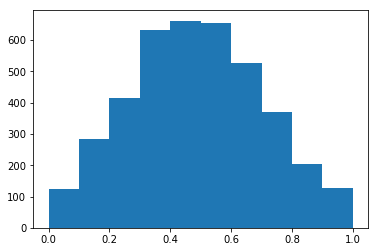

In [94]:
plt.hist(prop_anc["Prop_CEU"])
plt.show()

In [95]:
prop_anc[prop_anc["Prop_CEU"]<=0.2].shape

(407, 2)

In [96]:
prop_anc[prop_anc["Prop_CEU"]>=0.8].shape

(330, 2)

In [97]:
prop_anc[(prop_anc["Prop_CEU"]<0.8)&(prop_anc["Prop_CEU"]>0.2)].shape

(3263, 2)


100%|██████████| 1313100/1313100 [00:35<00:00, 68287.99it/s]

## Calculate True PRSs for all individuals

In [ ]:
import output_true_prs

Assume same causal variants and effect sizes

Average true PRS over a 100 iterations

In [ ]:
f = h5py.File('/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/true_prs/prs_m_1000_h2_0.67.hdf5', 'r')

In [ ]:
f.keys()

In [ ]:
f['labels'][()]

In [ ]:
ceu_anc_prop = [1]*(f['G'].shape[0]-prop_anc.shape[0])+list(prop_anc["Prop_CEU"])

In [ ]:
len(ceu_anc_prop)

In [ ]:
plt.scatter(x=f['G'][()],y=ceu_anc_prop)
plt.xlabel("True Polygenic Risk Score",fontsize=14)
plt.ylabel("Proportion European Ancestry",fontsize=14)
plt.show()

## Select Cases and Controls

In [ ]:
sns.distplot(f['G'][()])
plt.vlines(x=np.percentile(f['G'][()],95),ymin=0,ymax=0.5)
plt.show()

In [ ]:
sns.distplot(G+E)
plt.vlines(x=np.percentile(G+E,95),ymin=0,ymax=0.4)
plt.show()

In [ ]:
sns.distplot(meta_data.loc[eur_train_case,"truePRS"],color="red")
sns.distplot(meta_data.loc[eur_train_control,"truePRS"],color="blue")
plt.show()

In [ ]:
sns.distplot(meta_data.loc[eur_test_case,"truePRS"],color="red")
sns.distplot(meta_data.loc[eur_test_control,"truePRS"],color="blue")
plt.show()

In [ ]:
sns.distplot(meta_data.loc[meta_data.Disease==1,"truePRS"],color="red")
sns.distplot(meta_data.loc[meta_data.Disease==0,"truePRS"],color="blue")
plt.show()

## Perform GWAS with training European samples

#### Calculate MAF EUR

In [ ]:
tree = msprime.load(path_tree)
n_sites = tree.num_sites

#### Perform GWAS

In [ ]:
from statsmodels.stats import multitest

In [ ]:
sum_stats = pd.read_csv("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/comm_maf_0.01_sum_stats_m_{}_h2_{}.txt".format(m,h2),sep="\t",index_col=0)
_,cor_p,_,_ = multitest.multipletests(sum_stats.loc[:,"p-value"], method="fdr_bh")
sum_stats["fdr"]=cor_p
sum_stats.to_csv("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/comm_maf_0.01_sum_stats_m_{}_h2_{}_fdr.txt".format(m,h2),sep="\t")

## Calculate Expected PRS for everyone

In [ ]:
from output_emp_prs import *

In [ ]:
tree = msprime.load(path_tree)
n_sites = tree.num_sites

In [ ]:
bonf_p = 0.05/n_sites

In [ ]:
bonf_p

In [ ]:
sum_stats = pd.read_csv("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/comm_maf_0.01_sum_stats_m_{}_h2_{}_fdr.txt".format(m,h2),sep="\t",index_col=0)

In [ ]:
prs_vars = sum_stats[sum_stats["p-value"] < bonf_p].sort_values(by=["p-value"])

In [ ]:
prs_vars.shape

prs_vars.head(1000).tail(1)

ld_struct = find_ld_sites(tree, [229402],r2_threshold=0.2,num_threads=1)

In [98]:
f = h5py.File('/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/emp_prs/emp_prs_m_1000_h2_0.67_LD_ALL.hdf5', 'r')

In [99]:
f.keys()

<KeysViewHDF5 ['X', 'labels']>

In [100]:
f['labels'][()]

array([b'msp_0', b'msp_1', b'msp_2', ..., b'50c36e0f', b'35048bc5',
       b'1cb4b81d'], dtype='|S10')

In [101]:
emp = f['X'][()]
emp_Z = (emp - np.mean(emp))/np.std(emp)

In [102]:
f_LA = h5py.File('/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/emp_prs/emp_prs_m_1000_h2_0.67_LD_ALL_ADMIX_unweight_noneur.hdf5', 'r')
emp_LA = f_LA['X'][()]
emp_Z_LA = (emp_LA - np.mean(emp_LA))/np.std(emp_LA)
LA_only_labels = f_LA['labels'][()].astype(str)

In [103]:
t = h5py.File('/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/true_prs/prs_m_1000_h2_0.67.hdf5', 'r')

In [104]:
true = t['Zx'][()]

In [105]:
t['labels'][()]

array([b'msp_0', b'msp_1', b'msp_2', ..., b'50c36e0f', b'35048bc5',
       b'1cb4b81d'], dtype='|S10')

In [106]:
emp.shape

(199000,)

In [107]:
true.shape

(199000,)

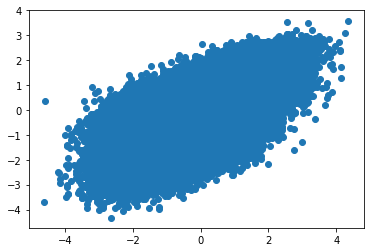

In [108]:
plt.scatter(true,emp_Z)
plt.show()

In [109]:
train_test = h5py.File("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/train_test_CEU_m_1000_h2_0.67.hdf5")

In [110]:
train_test.keys()

<KeysViewHDF5 ['test_cases', 'test_controls', 'train_cases', 'train_controls']>

In [111]:
training = np.append(train_test["train_controls"][()],train_test["train_cases"][()])
testing = np.append(train_test["test_controls"][()],train_test["test_cases"][()])

In [112]:
len(train_test["train_controls"][()])

90000

In [113]:
len(train_test["train_cases"][()])

9000

In [114]:
training_msp = ["msp_"+str(train) for train in training]
testing_msp = ["msp_"+str(test) for test in testing]

In [115]:
labels = t['labels'][()].astype(str)

In [116]:
label_inds = pd.DataFrame(np.arange(0,len(labels)),index = labels)
LA_label_inds = pd.DataFrame(np.arange(0,len(LA_only_labels)),index = LA_only_labels)

In [117]:
train_inds = label_inds.loc[training_msp,0].values
test_inds = label_inds.loc[testing_msp,0].values

In [118]:
admix = label_inds.loc[prop_anc.index,0].values
LA_admix = LA_label_inds.loc[prop_anc.index,0].values

In [119]:
low_admix = label_inds.loc[prop_anc[prop_anc["Prop_CEU"]>0.8].index,0].values
mid1 = label_inds.loc[prop_anc[(prop_anc["Prop_CEU"]>0.2)&(prop_anc["Prop_CEU"]<=0.4)].index,0].values
mid2 = label_inds.loc[prop_anc[(prop_anc["Prop_CEU"]>0.4)&(prop_anc["Prop_CEU"]<=0.6)].index,0].values
mid3 = label_inds.loc[prop_anc[(prop_anc["Prop_CEU"]>0.6)&(prop_anc["Prop_CEU"]<=0.8)].index,0].values
high_admix = label_inds.loc[prop_anc[prop_anc["Prop_CEU"]<=0.2].index,0].values

In [120]:
LA_low_admix = LA_label_inds.loc[prop_anc[prop_anc["Prop_CEU"]>0.8].index,0].values
LA_mid1 = LA_label_inds.loc[prop_anc[(prop_anc["Prop_CEU"]>0.2)&(prop_anc["Prop_CEU"]<=0.4)].index,0].values
LA_mid2 = LA_label_inds.loc[prop_anc[(prop_anc["Prop_CEU"]>0.4)&(prop_anc["Prop_CEU"]<=0.6)].index,0].values
LA_mid3 = LA_label_inds.loc[prop_anc[(prop_anc["Prop_CEU"]>0.6)&(prop_anc["Prop_CEU"]<=0.8)].index,0].values
LA_high_admix = LA_label_inds.loc[prop_anc[prop_anc["Prop_CEU"]<=0.2].index,0].values

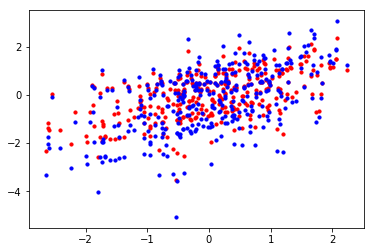

In [121]:
#plt.scatter(true[test_inds],emp_Z[test_inds],s=10,color="gray")
plt.scatter(true[low_admix],emp_Z[low_admix],color="red",s=10)
plt.scatter(true[low_admix],emp_Z_LA[LA_low_admix],color="blue",s=10)
#plt.scatter(true[high_admix],emp_Z[high_admix],color="red",s=10)
#plt.scatter(true[high_admix],emp_Z_LA[LA_high_admix],color="blue",s=10)
#plt.scatter(true[mid_admix],emp_Z[mid_admix],color="orange",s=10)

plt.show()

In [122]:
np.log(1)

0.0

In [123]:
len(test_inds)

4000

In [124]:
stats.pearsonr(true[test_inds],emp_Z[test_inds])

(0.6024851402914584, 0.0)

CEU > 0.8

In [125]:
len(low_admix)

330

In [126]:
stats.pearsonr(true[low_admix],emp_Z_LA[LA_low_admix])

(0.5475394232373694, 3.3015638101941344e-27)

In [127]:
stats.pearsonr(true[low_admix],emp_Z[low_admix])

(0.5485415286816869, 2.547565826699356e-27)

CEU <= 0.2

In [128]:
len(high_admix)

407

In [129]:
stats.pearsonr(true[high_admix],emp_Z_LA[LA_high_admix])

(0.2023236447313707, 3.926315849103007e-05)

In [130]:
stats.pearsonr(true[high_admix],emp_Z[high_admix])

(0.28164155338083435, 7.3869259609590965e-09)

In [131]:
prop_anc

,Prop_CEU,Prop_YRI
45649d28,0.260373,0.739627
029090f4,0.286307,0.713693
32a8c97e,0.198133,0.801867
5b7e5903,0.199170,0.800830
1b57a9be,0.411307,0.588693
4b790c69,0.494295,0.505705
36b361f9,0.864627,0.135373
03ee4a96,0.690353,0.309647
778b79c0,0.519710,0.480290
519778a9,0.350104,0.649896


0.2 < CEU <= 0.4

In [ ]:
stats.pearsonr(true[mid1],emp_Z[mid1])

0.4 < CEU <= 0.6

In [ ]:
stats.pearsonr(true[mid2],emp_Z[mid2])

0.6 < CEU <= 0.8

In [ ]:
stats.pearsonr(true[mid3],emp_Z[mid3])

In [ ]:
plt.scatter(true)

In [ ]:
true[test_inds]

In [ ]:
low_admix = label_inds.loc[prop_anc[prop_anc["Prop_CEU"]<0.2].index,0].values

In [ ]:
admix = label_inds.loc[prop_anc.index,0].values

### a: Using European GWAS

### b: Using Local-Ancestry Specific Approach (relies on significant SNPs from European GWAS)

## Calculate AUCs and compare between approaches

In [52]:
clumped_prs_vars = np.array(open("/Users/taylorcavazos/repos/Local_Ancestry_PRS/data/prs_vars_p_5e-8_r2_0.2.txt").read().splitlines()).astype(int)

In [87]:
sum_stats.loc[clumped_prs_vars,:].head(20)

,OR,p-value
var_id,,
2,0.615194,1.915182e-106
62,0.567920,4.435143e-11
65,0.606124,1.541818e-08
91,0.528590,1.392931e-58
176,1.389485,2.044740e-08
257,1.361532,7.746888e-24
295,0.575947,1.146586e-17
542,0.402226,9.177612e-20
745,1.831424,1.625924e-35


In [86]:
sum_stats.head(20)

,OR,p-value
var_id,,
2,0.615194,1.915182e-106
62,0.567920,4.435143e-11
63,0.615194,1.915182e-106
65,0.606124,1.541818e-08
91,0.528590,1.392931e-58
112,1.219332,7.424664e-13
128,0.495890,1.558270e-205
131,0.637340,8.151022e-91
148,1.363868,1.993075e-05


In [55]:
vcf_file = "/Users/taylorcavazos/repos/other_tools/admixture-data/output/admix_afr_amer.query.vcf"

In [63]:
afs = []
with open(vcf_file) as f:
    ind=0
    for line in f:
        if line[0] != "#":
            if ind in clumped_prs_vars:
                data = line.split("\t")[9:]
                genotype = np.array([np.array(hap.split("|")).astype(int).sum() for hap in data])
                af = genotype.sum()/(2*4000)
                afs.append(af)
            ind+=1

In [64]:
afs

[0.244875,
 0.000625,
 0.00675,
 0.01925,
 0.007375,
 0.100625,
 0.01375,
 0.003375,
 0.02,
 0.01875,
 0.009625,
 0.015125,
 0.038625,
 0.0085,
 0.004,
 0.146,
 0.016125,
 0.0035,
 0.269625,
 0.100625,
 0.015,
 0.006625,
 0.0345,
 0.008625,
 0.01875,
 0.020375,
 0.01375,
 0.00675,
 0.146,
 0.007875,
 0.000625,
 0.009625,
 0.018375,
 0.0085,
 0.02275,
 0.00475,
 0.006,
 0.244875,
 0.018625,
 0.0345,
 0.007,
 0.00675,
 0.100625,
 0.01375,
 0.01875,
 0.009625,
 0.007125,
 0.016125,
 0.0085,
 0.006,
 0.146,
 0.02275,
 0.003375,
 0.000625,
 0.00475,
 0.244875,
 0.0475,
 0.003875,
 0.015,
 0.004,
 0.0075,
 0.01375,
 0.100625,
 0.009625,
 0.016125,
 0.0085,
 0.015125,
 0.146,
 0.006,
 0.0035,
 0.038625,
 0.244875,
 0.0475,
 0.003375,
 0.007375,
 0.01875,
 0.00475,
 0.01375,
 0.0075,
 0.100625,
 0.000625,
 0.0085,
 0.016125,
 0.01225,
 0.009625,
 0.006625,
 0.006,
 0.02275,
 0.119875,
 0.0475,
 0.17225,
 0.007875,
 0.0035,
 0.01375,
 0.00475,
 0.007375,
 0.100625,
 0.0075,
 0.008625,
 0.0085,


In [67]:
0.615194/0.244875

2.512277692700357

In [73]:
np.log(0.567920)/0.000625

-905.2395444016106

In [72]:
np.log(0.567920)

-0.5657747152510066

In [79]:
causal_inds = np.linspace(0, n_sites, m, dtype=int,endpoint=False)

In [78]:
causal_inds

array([      0,    1313,    2626,    3939,    5252,    6565,    7878,
          9191,   10504,   11817,   13130,   14444,   15757,   17070,
         18383,   19696,   21009,   22322,   23635,   24948,   26261,
         27575,   28888,   30201,   31514,   32827,   34140,   35453,
         36766,   38079,   39392,   40706,   42019,   43332,   44645,
         45958,   47271,   48584,   49897,   51210,   52523,   53837,
         55150,   56463,   57776,   59089,   60402,   61715,   63028,
         64341,   65654,   66968,   68281,   69594,   70907,   72220,
         73533,   74846,   76159,   77472,   78785,   80099,   81412,
         82725,   84038,   85351,   86664,   87977,   89290,   90603,
         91916,   93230,   94543,   95856,   97169,   98482,   99795,
        101108,  102421,  103734,  105047,  106361,  107674,  108987,
        110300,  111613,  112926,  114239,  115552,  116865,  118178,
        119492,  120805,  122118,  123431,  124744,  126057,  127370,
        128683,  129